### Import packages

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef,confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

### Load in model and move to the GPU

In [ ]:
model_path = '/content/drive/MyDrive/NLU_Files/final_roberta_optimal_lr'
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

### Define prediction function that accepts claim and evidence, and define dataset class

In [ ]:
def predict(sentence1, sentence2):
    inputs = tokenizer(sentence1, sentence2, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
    return prediction

In [ ]:
# Dataset class to help us initialise and load datasets
class EDDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels) if self.labels is not None else len(self.encodings['input_ids'])

### Define dataframes and loaders for validation set

In [ ]:
# Load the validation dataset
val_df = pd.read_csv("/content/drive/MyDrive/NLU_Files/dev.csv")
val_encodings = tokenizer(val_df['Claim'].tolist(), val_df['Evidence'].tolist(),
                          truncation=True, padding='max_length', max_length=512, return_tensors="pt")
val_labels = val_df['label'].tolist() # Replace 'Label' with the actual label column name if different
val_dataset = EDDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Evaluate the model
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


### Check for class imbalance

In [ ]:
true_labels = val_df['label']  # Replace 'Label' with the actual column name for labels in your dataset
class_distribution = true_labels.value_counts()
print("Class distribution in the validation dataset:", class_distribution)

Class distribution in the validation dataset: label
0    4327
1    1599
Name: count, dtype: int64


#### Severe imbalance observed between 0s and 1s, so PR-AUC Score seems appropriate

### PR-AUC Score Calculation

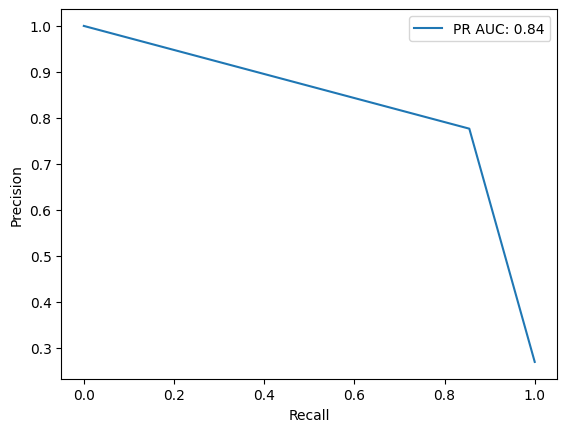

PR AUC: 0.8354


In [ ]:
# Calculate and plot Precision-Recall curve and AUC
precision, recall, _ = precision_recall_curve(true_labels, predictions)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'PR AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

print(f'PR AUC: {pr_auc:.4f}')

### Confusion Matrix

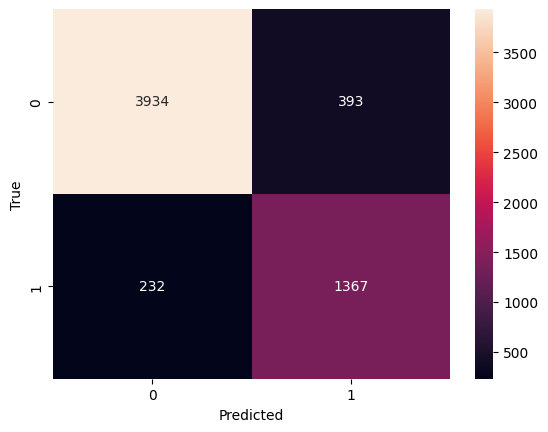

In [ ]:
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Other calculated metrics

In [ ]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
mcc = matthews_corrcoef(true_labels, predictions)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')

Accuracy: 0.8945325683428957
Precision: 0.8990861717238425
Recall: 0.8945325683428957
F1 Score: 0.8960604826127412
MCC: 0.7422376321991807


Overall Evaluation Result:

Very high accuracy, with overall reliability in predictions. Precision shows a high likelihood that positive predictions are correct. Recall is slightly lower, showing there is room for improvement in identifying all positives. F1 score shows a good balance between the two, and the MCC of 0.74 shows a strong correlation between observed and predicted classifications, even despite the imbalance.